# Session 7 - Tree-based Methods

## Contents

- [The Basics of Decision Trees](#The-Basics-of-Decision-Trees)
- [Bagging, Random Forests, Boosting](#Bagging,-Random-Forests,-Boosting)

In [1]:
# Import
import pandas as pd
import numpy as np
import seaborn as sns
import pydot
from IPython.display import Image
from six import StringIO  

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, mean_squared_error

In [2]:
# Import matplotlib for graphs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Set global parameters
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (12,5)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

## The Basics of Decision Trees

Decision trees involve **segmenting the predictor space into a number of simple regions**. In order to make a prediction for a given observation, we typically use the mean or the mode of the training observations in the region to which it belongs. Since the set of splitting rules used to segment the predictor space can be summarized in a tree, these types of approaches are known as decision tree methods.

### Regression Trees

For this session we will consider the `Hitters` dataset. It consists in individual level data of baseball players. In our applications, we are interested in predicting the players `Salary`.

In [3]:
# Load the data
hitters = pd.read_csv('data/Hitters.csv').dropna()
hitters.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N
5,-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,...,501,336,194,A,W,282,421,25,750.0,A


In particular, we are interested in looking how the number of `Hits` and the `Years` of experience predict the salary.

In [4]:
# Get Features
features = ['Years', 'Hits']
X = hitters[features].values
y = np.log(hitters.Salary.values)

We are actually going to use log(salary) since it has a more gaussian distribution.

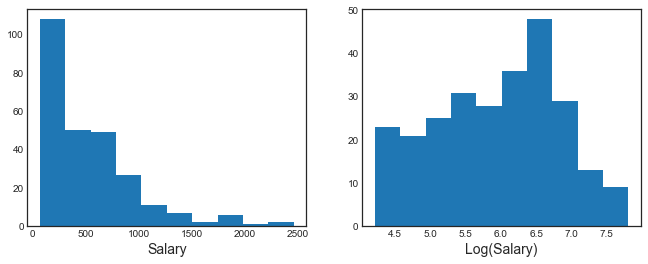

In [5]:
# Plot salary distribution
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))
ax1.hist(hitters.Salary.values)
ax1.set_xlabel('Salary')
ax2.hist(y)
ax2.set_xlabel('Log(Salary)');

In order to understand what is a tree, let's first have a look at one. We fit a regression three with 3 leaves or, equivalently put, 2 nodes.

In [6]:
# Fit regression tree
tree = DecisionTreeRegressor(max_leaf_nodes=3)
tree.fit(X, y)

DecisionTreeRegressor(max_leaf_nodes=3)

We are now going to plot the results visually. The biggest avantage of trees is interpretability.

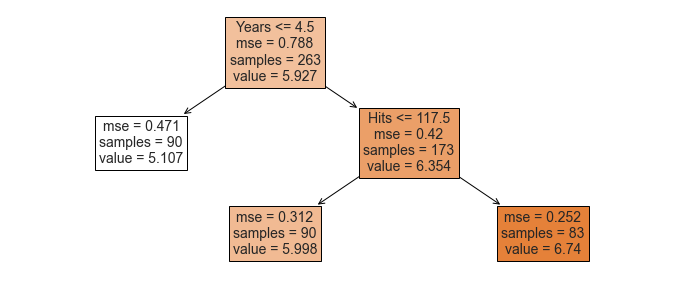

In [7]:
# Figure 8.1
fig, ax = plt.subplots(1,1)
ax.set_title('Figure 8.1');

# Plot tree
plot_tree(tree, filled=True, feature_names=features, fontsize=14, ax=ax);

The tree consists of a series of splitting rules, starting at the top of the tree. The top split assigns observations having `Years`<4.5 to the left branch.1 The predicted salary for these players is given by the mean response value for the players in the data set with `Years`<4.5. For such players, the mean log salary is 5.107, and so we make a prediction of 5.107 thousands of dollars, i.e. $165,174, for these players. Players with `Years`>=4.5 are assigned to the right branch, and then that group is further subdivided by `Hits`. 

Overall, the tree stratifies or segments the players into three regions of predictor space:
1. players who have played for four or fewer years
2. players who have played for five or more years and who made fewer than 118 hits last year, and
3. players who have played for five or more years and who made at least 118 hits last year. 

These three regions can be written as 
1. **R1** = {X | `Years`<4.5}
2. **R2** = {X | `Years`>=4.5, `Hits`<117.5}, and 
3. **R3** = {X | `Years`>=4.5, `Hits`>=117.5}. 

Since the dimension of $X$ is 2, we can visualize the space and the regions in a 2-dimensional graph.

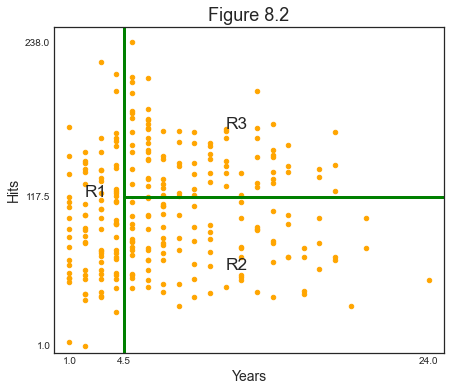

In [8]:
# Figure 8.2
hitters.plot('Years', 'Hits', kind='scatter', color='orange', figsize=(7,6))
plt.title('Figure 8.2')
plt.xlim(0,25); plt.ylim(ymin=-5);
plt.xticks([1, 4.5, 24]); plt.yticks([1, 117.5, 238]);

# Split lines
plt.vlines(4.5, ymin=-5, ymax=250, color='g')
plt.hlines(117.5, xmin=4.5, xmax=25, color='g')

# Regions
plt.annotate('R1', xy=(2,117.5), fontsize='xx-large')
plt.annotate('R2', xy=(11,60), fontsize='xx-large')
plt.annotate('R3', xy=(11,170), fontsize='xx-large');

We might **interpret** the above regression tree as follows: Years is the most important factor in determining Salary, and players with less experience earn lower salaries than more experienced players. Given that a player is less experienced, the number of hits that he made in the previous year seems to play little role in his salary. But among players who have been in the major leagues for five or more years, the number of hits made in the previous year does affect salary, and players who made more hits last year tend to have higher salaries.

#### Building a tree

There are two main steps in the construction of a tree:

1. We divide the predictor space—that is, the set of possible values for $X_1, X_2, ... , X_p$ into $J$ distinct and non-overlapping regions, $R_1,R_2,...,R_J$.
2. For every observation that falls into the region $R_j$ , we make the same prediction, which is simply the mean of the response values for the training observations in $R_j$.

The second step is easy. But how does one construct the regions? Our purpose is to minimize the Sum of Squared Residuals, across the different regions:

$$
\sum_{j=1}^{J} \sum_{i \in R_{j}}\left(y_{i}-\hat{y}_{R_{j}}\right)^{2}
$$

Unfortunately, it is computationally infeasible to consider every possible partition of the feature space into $J$ boxes. For this reason, we take a **top-down**, **greedy** approach that is known as *recursive binary splitting*. The approach is top-down because it begins at the top of the tree (at which point all observations belong to a single region) and then successively splits the predictor space; each split is indicated via two new branches further down on the tree. It is greedy because at each step of the tree-building process, the best split is made at that particular step, rather than looking ahead and picking a split that will lead to a better tree in some future step.

In practice, the method is the following:

1. we select the predictor $X_j$
2. we select the cutpoint $s$ such that splitting the predictor space into the regions $\{X|X_j < s\}$ and $\{X|X_j \geq s\}$ leads to the greatest possible reduction in RSS
3. we repeat (1)-(2) for all predictors $X_1, ... , X_p$, i.e. we solve

$$
\arg \min_{j,s} \ \sum_{i: x_{i} \in \{X|X_j < s\}}\left(y_{i}-\hat{y}_i\right)^{2}+\sum_{i: x_{i} \in \{X|X_j \geq s\}}\left(y_{i}-\hat{y}_i\right)^{2}
$$

4. we choose the predictor and cutpoint such that the resulting tree has the lowest RSS
6. we keep repeating (1)-(4) until a certain condition is met. However, after the first iteration we also have to pick which region to split which adds a further dimension to optimize over.

In [159]:
class Node:
    """
    Class used to represent nodes in a Regression Tree
    
    Attributes
    ----------
    x : np.array
        independent variables
    y : np.array
        dependent variables
    idxs : np.array
        indexes fo x and y for current node
    depth : int
        depth of the sub-tree (default 5)

    Methods
    -------
    find_next_nodes(self)
        Keep growing the tree
        
    find_best_split(self)
        Find the best split
        
    split(self)
        Split the tree
    """

    def __init__(self, x, y, idxs, depth=5):
        self.x = x
        self.y = y
        self.idxs = idxs 
        self.depth = depth
        self.find_next_nodes()
        
    def find_next_nodes(self):
        if self.is_last_leaf: return # Stop if last leaf 
        self.find_best_split()       # Get best split
        self.split()                 # Split
        
    def find_best_split(self):
        score = float('inf')
        # Loop over variables
        for col in range(self.x.shape[1]):
            x = self.x[self.idxs, col]
            # Loop over all splits
            for row in range(x.shape[0]):
                lhs = x <= x[row]
                rhs = x > x[row]
                curr_score = self.get_score(lhs, rhs)
                # If best score, save it 
                if curr_score < score: 
                    score = curr_score
                    self.split_col = col
                    self.split_val = x[row]
        
        return self
                
    def get_score(self, lhs, rhs):
        y = self.y[self.idxs]
        lhs_mse = self.get_mse(y[lhs])
        rhs_mse = self.get_mse(y[rhs])
        return lhs_mse * lhs.sum() + rhs_mse * rhs.sum()
    
    def get_mse(self, y): return np.mean((y-np.mean(y))**2)
      
    def split(self): 
        x = self.x[self.idxs, self.split_col]
        lhs = x <= self.split_val
        rhs = x > self.split_val
        self.lhs = Node(self.x, self.y, self.idxs[lhs], self.depth-1)
        self.rhs = Node(self.x, self.y, self.idxs[rhs], self.depth-1)
        to_print = (self.depth, self.split_col, self.split_val, sum(lhs), sum(rhs))
        print('Split on layer %.0f: var%1.0f = %.4f (%.0f/%.0f)' % to_print)
        return self
                
    @property
    def is_last_leaf(self): return self.depth<=1      

In [160]:
# Init first node
tree1 = Node(X, y, np.arange(len(y)), 1)

# Documentation
print(tree1.__doc__)


    Class used to represent nodes in a Regression Tree
    
    Attributes
    ----------
    x : np.array
        independent variables
    y : np.array
        dependent variables
    idxs : np.array
        indexes fo x and y for current node
    depth : int
        depth of the sub-tree (default 5)

    Methods
    -------
    find_next_nodes(self)
        Keep growing the tree
        
    find_best_split(self)
        Find the best split
        
    split(self)
        Split the tree
    


In [161]:
# Inspect the class
dir(tree1)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'depth',
 'find_best_split',
 'find_next_nodes',
 'get_mse',
 'get_score',
 'idxs',
 'is_last_leaf',
 'split',
 'x',
 'y']

In [162]:
# Get info
print('Tree of depth %.0f with %.0f observations' % (tree1.depth, len(tree1.idxs)))

Tree of depth 1 with 263 observations


In [163]:
# Check if terminal
tree1.is_last_leaf

True

In [164]:
# Find best split
tree1.find_best_split()
print('Split at var%1.0f = %.4f' % (tree1.split_col, tree1.split_val))

Split at var0 = 4.0000


In [165]:
# Split tree
tree1.split();

Split on layer 1: var0 = 4.0000 (90/173)


Now we are ready to split the whole tree

In [166]:
# Check depth-3 tree
node = Node(X, y, np.arange(len(y)), 3)

Split on layer 2: var1 = 4.0000 (2/88)
Split on layer 2: var1 = 117.0000 (90/83)
Split on layer 3: var0 = 4.0000 (90/173)


#### Pruning

The process described above may produce good predictions on the training set, but is likely to overfit the data, leading to poor test set performance. This is because the resulting tree might be too complex. A smaller tree with fewer splits might lead to lower variance and better interpretation at the cost of a little bias. 

One possible alternative to the process described above is to build the tree only so long as the decrease in the RSS due to each split exceeds some (high) threshold.

This strategy will result in smaller trees, but is too short-sighted since a seemingly worthless split early on in the tree might be followed by a very good split—that is, a split that leads to a large reduction in RSS later on.

We can use cross-validation to pick the optimal tree length.

In [9]:
# Import original split
features = ['Years', 'Hits', 'RBI', 'PutOuts', 'Walks', 'Runs', 'AtBat', 'HmRun']
X_train = pd.read_csv('data/Hitters_X_train.csv').dropna()[features]
X_test = pd.read_csv('data/Hitters_X_test.csv').dropna()[features]
y_train = pd.read_csv('data/Hitters_y_train.csv').dropna()
y_test = pd.read_csv('data/Hitters_y_test.csv').dropna()

In [10]:
# Init
params = range(2,11)
reg_scores = np.zeros((len(params),3))
best_score = 10**6

# Loop over all parameters
for i,k in enumerate(params):
    
    # Model
    tree = DecisionTreeRegressor(max_leaf_nodes=k)

    # Loop over splits
    tree.fit(X_train, y_train)
    reg_scores[i,0] = mean_squared_error(tree.predict(X_train), y_train)
    reg_scores[i,1] = mean_squared_error(tree.predict(X_test), y_test)

    # Get CV score
    kf6 = KFold(n_splits=6)
    reg_scores[i,2] = -cross_val_score(tree, X_train, y_train, cv=kf6, scoring='neg_mean_squared_error').mean()
    
    # Save best model
    if reg_scores[i,2]<best_score:
        best_model = tree
        best_score = reg_scores[i,2]

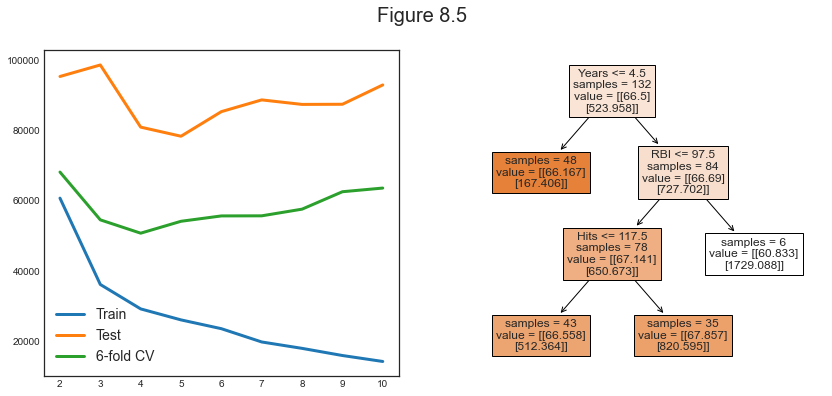

In [11]:
# Figure 8.5
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))
fig.suptitle('Figure 8.5')

# Plot scores
ax1.plot(params, reg_scores);
ax1.legend(['Train','Test','6-fold CV']);

# Plot best tree
plot_tree(best_model, filled=True, impurity=False, feature_names=features, fontsize=12, ax=ax2);

### Classification Trees

A classification tree is very similar to a regression tree, except that it is used to predict a qualitative response rather than a quantitative one.

For a classification tree, we predict that each observation belongs to the most commonly occurring class of training observations in the region to which it belongs.

#### Building a classification tree

The task of growing a classification tree is similar to the task of growing a regression tree. However, in the classification setting, RSS cannot be used as a criterion for making the binary splits.

We define $\hat p_{mk}$ as the proportion of training observations in the $m^{th}$ region that are from the $k^{th}$ class. Possible loss functions to decide the splits are:

- the classification error rate

$$
E = 1 - \max _{k}\left(\hat{p}_{m k}\right)
$$

- the Gini index

$$
G=\sum_{k=1}^{K} \hat{p}_{m k}\left(1-\hat{p}_{m k}\right)
$$

- entropy

$$
D=-\sum_{k=1}^{K} \hat{p}_{m k} \log \hat{p}_{m k}
$$

When building a classification tree, either the Gini index or the entropy are typically used to evaluate the quality of a particular split, since these two approaches are more sensitive to node purity than is the classification error rate. 

For this section we will work with the `Heart` dataset on individual heart failures. We will try to use individual characteristics in order to predict heart deseases (`HD`). The varaible is binary: Yes, No.

In [12]:
# Load heart dataset
heart = pd.read_csv('Data/Heart.csv').drop('Unnamed: 0', axis=1).dropna()
heart.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [13]:
# Fastorize variables
heart.ChestPain = pd.factorize(heart.ChestPain)[0]
heart.Thal = pd.factorize(heart.Thal)[0]

In [14]:
# Set features
features = [col for col in heart.columns if col!='AHD']
X2 = heart[features]
y2 = pd.factorize(heart.AHD)[0]

We now fit our classifier.

In [15]:
# Fit classification tree
clf = DecisionTreeClassifier(max_depth=None, max_leaf_nodes=11)
clf.fit(X2,y2)

DecisionTreeClassifier(max_leaf_nodes=11)

In [16]:
# Final score
clf.score(X2,y2)

0.8686868686868687

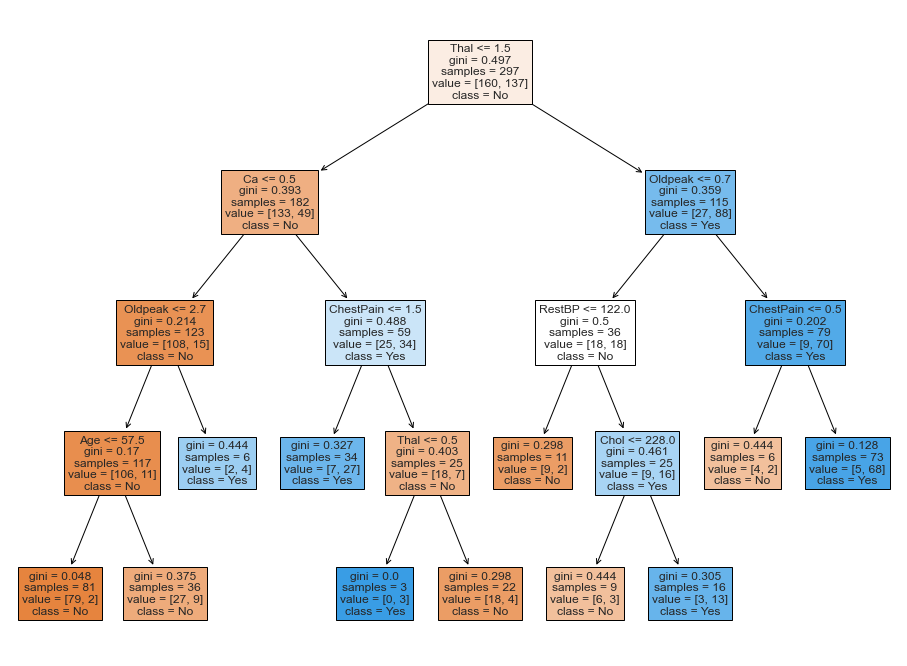

In [17]:
# Figure 8.6
fig, ax = plt.subplots(1,1, figsize=(16,12))
ax.set_title('Figure 8.6');

# Plot tree
plot_tree(clf, filled=True, feature_names=features, class_names=['No','Yes'], fontsize=12, ax=ax);

This figure has a surprising characteristic: some of the splits yield two terminal nodes that have the same predicted value. 

For instance, consider the split `Age`<=57.5 near the bottom left of the unpruned tree. Regardless of the value of `Age`, a response value of *No* is predicted for those observations. Why, then, is the split performed at all? 

The split is performed because it leads to increased node purity. That is, 2/81 of the observations corresponding to the left-hand leaf have a response value of *Yes*, whereas 9/36 of those corresponding to the right-hand leaf have a response value of *Yes*. Why is node purity important? Suppose that we have a test observation that belongs to the region given by that left-hand leaf. Then we can be pretty certain that its response value is *No*. In contrast, if a test observation belongs to the region given by the right-hand leaf, then its response value is probably *No*, but we are much less certain. Even though the split `Age`<=57.5 does not reduce the classification error, it improves the Gini index and the entropy, which are more sensitive to node purity.

#### Pruning

We can repeat the pruning exercise also for the classification task.

In [18]:
# Init
J = 10
params = range(2,11)
clf_scores = np.zeros((len(params),3))
best_score = 100

# Loop over all parameters
for i,k in enumerate(params):
    
    # Model
    tree = DecisionTreeClassifier(max_leaf_nodes=k)
    
    # Loop J times
    temp_scores = np.zeros((J,3))
    for j in range (J):

        # Loop over splits
        X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.5, random_state=j)
        m = tree.fit(X2_train, y2_train)
        temp_scores[j,0] = mean_squared_error(m.predict(X2_train), y2_train)
        temp_scores[j,1] = mean_squared_error(m.predict(X2_test), y2_test)

        # Get CV score
        kf6 = KFold(n_splits=6)
        temp_scores[j,2] = -cross_val_score(tree, X2_train, y2_train, cv=kf6, scoring='neg_mean_squared_error').mean()
        
        # Save best model
        if temp_scores[j,2]<best_score:
            best_model = m
            best_score = temp_scores[j,2]
        
    # Average
    clf_scores[i,:] = np.mean(temp_scores, axis=0)

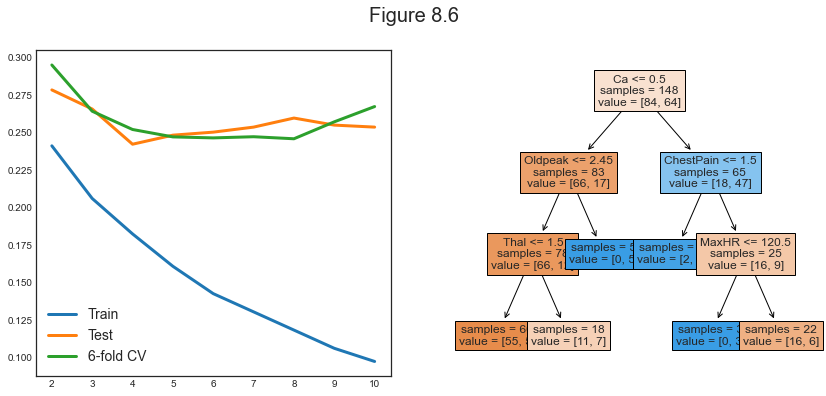

In [19]:
# Figure 8.6
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6))
fig.suptitle('Figure 8.6')

# Plot scores
ax1.plot(params, clf_scores);
ax1.legend(['Train','Test','6-fold CV']);

# Plot best tree
plot_tree(best_model, filled=True, impurity=False, feature_names=features, fontsize=12, ax=ax2);

#### Trees vs Regression

**Advantages**

- Trees are very easy to explain to people. In fact, they are even easier to explain than linear regression!
- Some people believe that decision trees more closely mirror human decision-making than do the regression and classification approaches seen in previous chapters.
- Trees can be displayed graphically, and are easily interpreted even by a non-expert (especially if they are small).
- Trees can easily handle qualitative predictors without the need to create dummy variables.

**Disadvantages**

- trees generally do not have the same level of predictive accuracy as some of the other regression and classification approaches seen in this book.
- trees can be very non-robust. In other words, a small change in the data can cause a large change in the final estimated tree.

## Bagging, Random Forests, Boosting

Bagging, random forests, and boosting use trees as building blocks to construct more powerful prediction models.

### Bagging

The main problem of decision trees is that they suffer from **high variance**. *Bootstrap aggregation*, or *bagging*, is a general-purpose procedure for reducing the variance of a statistical learning method.

The main idea behind *bagging* is tha,t given a set of n independent observations $Z_1,...,Z_n$, each with variance $\sigma^2$, the variance of the mean $\bar Z$ of the observations is given by $\sigma^2/n$. In other words, averaging a set of observations reduces variance.

Indeed *bagging* consists in taking many training sets from the population, build a separate prediction model using each training set, and **average the resulting predictions**. Since we do not have access to many training sets, we resort to bootstrapping.

#### Out-of-Bag Error Estimation

It turns out that there is a very straightforward way to estimate the test error of a bagged model, without the need to perform cross-validation or the validation set approach. Recall that the key to bagging is that trees are repeatedly fit to bootstrapped subsets of the observations. One can show that on average, each bagged tree makes use of around two-thirds of the observations. The remaining one-third of the observations not used to fit a given bagged tree are referred to as the out-of-bag (OOB) observations. We can predict the response for the ith observation using each of the trees in which that observation was OOB.

We are now going to compute the Gini index for the `Heart` dataset using different numbers of trees.

In [20]:
# Init
params = range(2,50)
bagging_scores = np.zeros((len(params),2))
J = 10;

# Loop over parameters
for i, k in enumerate(params):
    print("Computing k=%1.0f" % k, end ="")
    
    # Repeat J 
    temp_scores = np.zeros((J,2))
    for j in range(J):
        X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.5, random_state=j)
        bagging = BaggingClassifier(DecisionTreeClassifier(), max_samples=k, oob_score=True)
        bagging.fit(X2_train,y2_train)
        temp_scores[j,0] = bagging.score(X2_test, y2_test)
        temp_scores[j,1] = bagging.oob_score_
        
    # Average
    bagging_scores[i,:] = np.mean(temp_scores, axis=0)
    print("", end="\r")

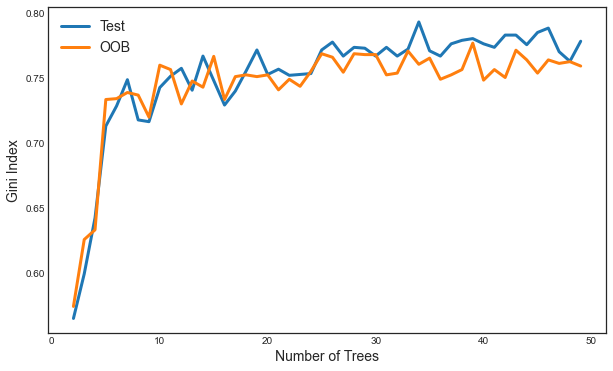

In [21]:
fig, ax = plt.subplots(1,1,figsize=(10,6))

# Plot scores
ax.plot(params, bagging_scores);
ax.legend(['Test','OOB']);
ax.set_xlabel('Number of Trees'); ax.set_ylabel('Gini Index');

It can be shown that with B sufficiently large, OOB error is virtually equivalent to leave-one-out cross-validation error. The OOB approach for estimating the test error is particularly convenient when performing bagging on large data sets for which cross-validation would be computationally onerous.

#### Variable Importance Measures

As we have discussed, the main advantage of bagging is to reduce prediction variance. However, with bagging it can be difficult to interpret the resulting model. In fact we cannot draw trees anymore given we have too many of them.

However, one can obtain an overall summary of the importance of each predictor using the RSS (for bagging regression trees) or the Gini index (for bagging classification trees). In the case of bagging regression trees, we can record the total amount that the RSS is decreased due to splits over a given predictor, averaged over all trees. A large value indicates an important predictor. Similarly, in the context of bagging classification trees, we can add up the total amount that the Gini index is decreased by splits over a given predictor, averaged over all trees.

In [22]:
# Compute feature importance
feature_importances = np.mean([tree.feature_importances_ for tree in bagging.estimators_], axis=0)

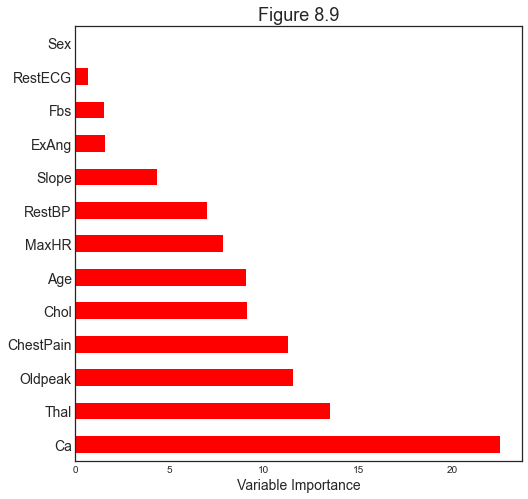

In [23]:
# Figure 8.9
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_title('Figure 8.9');

# Plot feature importance
h1 = pd.DataFrame({'Importance':feature_importances*100}, index=features)
h1 = h1.sort_values(by='Importance', axis=0, ascending=False)
h1.plot(kind='barh', color='r', ax=ax)
ax.set_xlabel('Variable Importance'); 
plt.yticks(fontsize=14);
plt.gca().legend_ = None;

### Random Forests

Random forests provide an improvement over bagged trees by way of a small tweak that decorrelates the trees. As in bagging, we build a number of decision trees on bootstrapped training samples. But when building these decision trees, each time a split in a tree is considered, a random sample of m predictors is chosen as split candidates from the full set of $p$ predictors. The split is allowed to use only one of those m predictors. A fresh sample of m predictors is taken at each split, and typically we choose $m \sim \sqrt{p}$ — that is, the number of predictors considered at each split is approximately equal to the square root of the total number of predictors

In other words, in building a random forest, at each split in the tree, the algorithm is not even allowed to consider a majority of the available predictors. This may sound crazy, but it has a clever rationale. Suppose that there is one very strong predictor in the data set, along with a number of other moderately strong predictors. Then in the collection of bagged trees, most or all of the trees will use this strong predictor in the top split. Consequently, all of the bagged trees will look quite similar to each other. Hence the predictions from the bagged trees will be highly correlated. Un- fortunately, averaging many highly correlated quantities does not lead to as large of a reduction in variance as averaging many uncorrelated quantities. In particular, this means that bagging will not lead to a substantial reduction in variance over a single tree in this setting.

Random forests overcome this problem by forcing each split to consider only a subset of the predictors. 

In [24]:
import warnings
warnings.simplefilter('ignore')

# Init
params = range(2,50)
forest_scores = np.zeros((len(params),2))
J = 10

# Loop over parameters
for i, k in enumerate(params):
    print("Computing k=%1.0f" % k, end ="")
    
    # Repeat J 
    temp_scores = np.zeros((J,2))
    for j in range(J):
        X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.5, random_state=j)
        forest = RandomForestClassifier(n_estimators=k, oob_score=True, max_features="sqrt")
        forest.fit(X2_train,y2_train)
        temp_scores[j,0] = forest.score(X2_test, y2_test)
        temp_scores[j,1] = forest.oob_score_
        
    # Average
    forest_scores[i,:] = np.mean(temp_scores, axis=0)
    print("", end="\r")

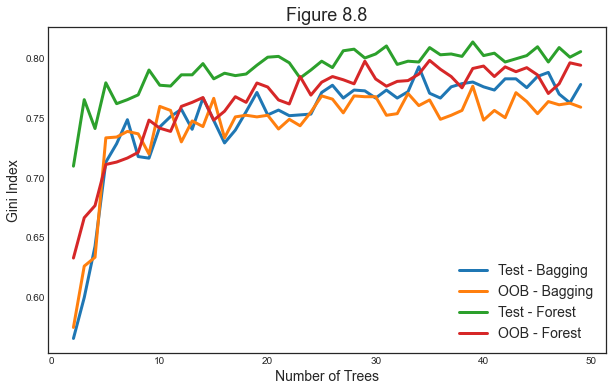

In [25]:
# Figure 8.8
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('Figure 8.8');

# Plot scores
ax.plot(params, bagging_scores);
ax.plot(params, forest_scores);
ax.legend(['Test - Bagging','OOB - Bagging', 'Test - Forest','OOB - Forest']);
ax.set_xlabel('Number of Trees'); ax.set_ylabel('Gini Index');

As for bagging, we can plot feature importance.

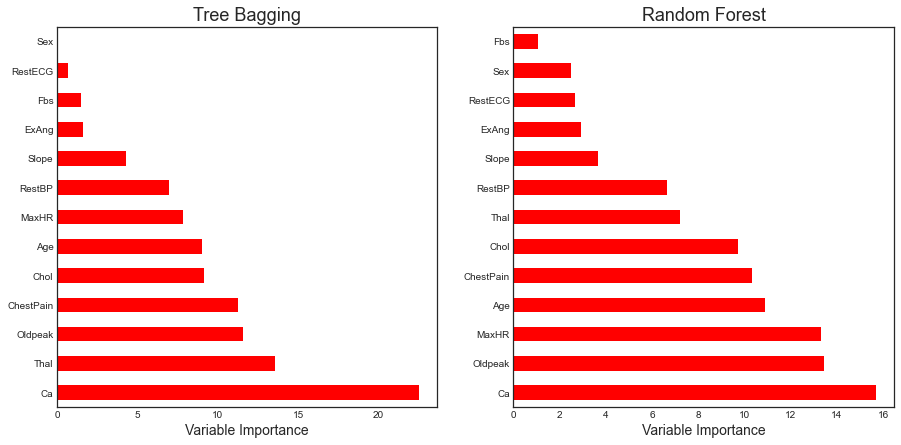

In [26]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7))


# Plot feature importance - Bagging
h1.plot(kind='barh', color='r', ax=ax1)
ax1.set_xlabel('Variable Importance'); 
ax1.set_title('Tree Bagging')

# Plot feature importance
h2 = pd.DataFrame({'Importance':forest.feature_importances_*100}, index=features)
h2 = h2.sort_values(by='Importance', axis=0, ascending=False)
h2.plot(kind='barh', color='r', ax=ax2)
ax2.set_title('Random Forest')

# All plots
for ax in fig.axes:
    ax.set_xlabel('Variable Importance'); 
    ax.legend([])

From the figure we observe that varaible importance ranking is similar with bagging and random forests, but there are significant differences.

We are now going to look at the importance of random forests using the `Khan` gene dataset. This dataset has the peculiarity of having a large number of features and very few observations.

In [27]:
# Load data
gene = pd.read_csv('data/Khan.csv')
print(len(gene))
gene.head()

83


,x,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V2299,V2300,V2301,V2302,V2303,V2304,V2305,V2306,V2307,V2308
0,2,0.773344,-2.438405,-0.482562,-2.721135,-1.217058,0.827809,1.342604,0.057042,0.133569,...,-0.238511,-0.027474,-1.660205,0.588231,-0.463624,-3.952845,-5.496768,-1.414282,-0.647600,-1.763172
1,2,-0.078178,-2.415754,0.412772,-2.825146,-0.626236,0.054488,1.429498,-0.120249,0.456792,...,-0.657394,-0.246284,-0.836325,-0.571284,0.034788,-2.478130,-3.661264,-1.093923,-1.209320,-0.824395
2,2,-0.084469,-1.649739,-0.241307,-2.875286,-0.889405,-0.027474,1.159300,0.015676,0.191942,...,-0.696352,0.024985,-1.059872,-0.403767,-0.678653,-2.939352,-2.736450,-1.965399,-0.805868,-1.139434
3,2,0.965614,-2.380547,0.625297,-1.741256,-0.845366,0.949687,1.093801,0.819736,-0.284620,...,0.259746,0.357115,-1.893128,0.255107,0.163309,-1.021929,-2.077843,-1.127629,0.331531,-2.179483
4,2,0.075664,-1.728785,0.852626,0.272695,-1.841370,0.327936,1.251219,0.771450,0.030917,...,-0.200404,0.061753,-2.273998,-0.039365,0.368801,-2.566551,-1.675044,-1.082050,-0.965218,-1.836966


The dataset has 83 rows and 2309 columns.

In [28]:
# Reduce dataset size
gene_small = gene.iloc[:,0:202]
X = gene_small.iloc[:,1:]
y = gene_small.iloc[:,0]

In [29]:
# Init
params = range(50,150,10)
m_scores = np.zeros((len(params),3))
p = np.shape(X)[1]
J = 5;

# Loop over parameters
for i, k in enumerate(params):
    
    # Array of features
    ms = [p, round(p/2), round(p**.5)]
    
    # Repeat L times
    temp_scores = np.zeros((J,3))
    for j in range(J):
        print("Computing k=%1.0f (iter=%1.0f)" % (k,j+1), end ="")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, random_state=j)
    
        # Loop over values of m
        for l, m in enumerate(ms):
            forest = RandomForestClassifier(n_estimators=k, max_features=m)
            forest.fit(X_train, y_train)
            temp_scores[j,l] = forest.score(X_test, y_test)
        print("", end="\r")
            
    # Average
    m_scores[i,:] = np.mean(temp_scores, axis=0)

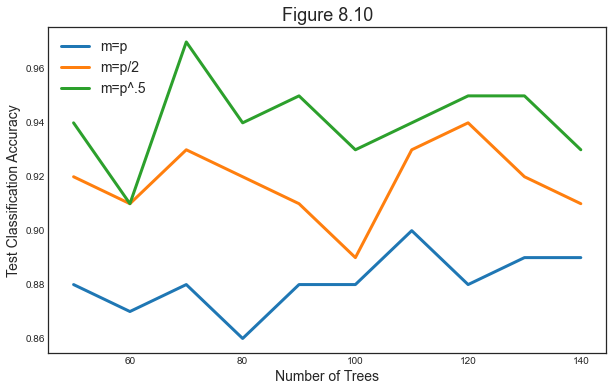

In [30]:
# Figure 8.10
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('Figure 8.10');

# Plot scores
ax.plot(params, m_scores);
ax.legend(['m=p','m=p/2','m=p^.5']);
ax.set_xlabel('Number of Trees'); ax.set_ylabel('Test Classification Accuracy');

### Boosting

Like bagging, boosting is a general approach that can be applied to many statistical learning methods for regression or classification. Here we restrict our discussion of boosting to the context of decision trees.

Boosting works similarly to bagging, except that the trees are grown sequentially: each tree is grown using information from previously grown trees. Boosting does not involve bootstrap sampling; instead each tree is fit on a modified version of the original data set.

What is the idea behind this procedure? Given the current model, we fit a decision tree to the residuals from the model. That is, **we fit a tree using the current residuals**, rather than the outcome $y$, as the response. We then add this new decision tree into the fitted function in order to update the residuals. Each of these trees can be rather small, with just a few terminal nodes, determined by the parameter $d$ in the algorithm. By fitting small trees to the residuals, **we slowly improve $\hat f$ in areas where it does not perform well**. The shrinkage parameter λ slows the process down even further, allowing more and different shaped trees to attack the resid- uals. In general, statistical learning approaches that learn slowly tend to perform well. 

#### Algorithm

The boosting algorithm works as follows:

1. Set $\hat f(x)=0$ and $r_i=y_i$ for all $i$ in the training set.
2. For $b=1,2,...,B$ repeat:
    a. Fit a tree $\hat fˆb$ with $d$ splits ($d+1$ terminal nodes) to the training data $(X,r)$.
    b. Update $\hat f$ by adding in a shrunken version of the new tree:
    $$
    \hat f(x) \leftarrow \hat f(x) + \hat f^b(x)
    $$
    c. Update the residuals
    $$
    r_i = r_i - \lambda \hat f^b(x_i)
    $$
3. Output the boosted model
$$
\hat{f}(x)=\sum_{b=1}^{B} \lambda \hat{f}^{b}(x)
$$

Boosting has three tuning parameters:

1. The number of trees B
2. The shrinkage parameter $\lambda$. This controls the rate at which boosting learns.
3. The number $d$ of splits in each tree, which controls the complexity of the boosted ensemble. Often d = 1 works well, in which case each tree is a stump, consisting of a single split.

In [31]:
# Init
params = range(50,150,10)
boost_scores = np.zeros((len(params),3))
p = np.shape(X)[1]
J = 5

# Loop over parameters
for i, k in enumerate(params):
    
    # Repeat L times
    temp_scores = np.zeros((J,3))
    for j in range(J):
        print("Computing k=%1.0f (iter=%1.0f)" % (k,j+1), end ="")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, random_state=j)
    
        # First score: random forest
        forest = RandomForestClassifier(n_estimators=k, max_features="sqrt")
        forest.fit(X_train, y_train)
        temp_scores[j,0] = forest.score(X_test, y_test)

        # Second score: boosting with 1-split trees
        boost1 = GradientBoostingClassifier(learning_rate=0.01, max_depth=1)
        boost1.fit(X_train, y_train)
        temp_scores[j,1] = boost1.score(X_test, y_test)

        # Third score: boosting with 1-split trees
        boost2 = GradientBoostingClassifier(learning_rate=0.01, max_depth=2)
        boost2.fit(X_train, y_train)
        temp_scores[j,2] = boost2.score(X_test, y_test)
        print("", end="\r")
    
    # Average
    boost_scores[i,:] = np.mean(temp_scores, axis=0)

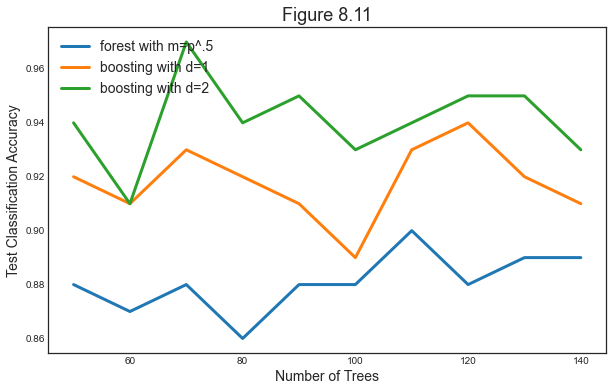

In [32]:
# Figure 8.11
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('Figure 8.11');

# Plot scores
ax.plot(params, m_scores);
ax.legend(['forest with m=p^.5','boosting with d=1','boosting with d=2']);
ax.set_xlabel('Number of Trees'); ax.set_ylabel('Test Classification Accuracy');

## Next Session

Jump to [Session 8 - Neural Networks](https://nbviewer.jupyter.org/github/matteocourthoud/Machine-Learning-for-Economic-Analysis-2020/blob/master/8_neuralnets.ipynb)